<a href="https://colab.research.google.com/github/Jonny-T87/ML-Projects/blob/main/AlphaVantageBacktesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
#!pip install ta
#!pip install alpha_vantage

In [178]:
import pandas as pd
import numpy as np
import ta
from alpha_vantage.timeseries import TimeSeries

In [179]:
api_key = '48NWJANFMLOGHP0D'

In [180]:
# Initialize the TimeSeries object
ts = TimeSeries(key=api_key, output_format='pandas')

In [181]:
data, meta_data = ts.get_intraday(symbol='QQQ', interval='5min', outputsize='full', month='2024-07-05')

In [182]:
data.to_csv('qqq_historical_data.csv')

In [183]:
# Load historical data
data = pd.read_csv('qqq_historical_data.csv', parse_dates=True, index_col=0)

In [184]:
data.sort_index(inplace=True)

In [185]:
data.rename(columns={'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. volume': 'volume'}, inplace=True)

In [186]:
data.head()

,open,high,low,close,volume
date,,,,,
2024-07-08 04:00:00,495.00,495.95,495.00,495.90,8362.0
2024-07-08 04:05:00,495.90,495.98,495.81,495.91,8310.0
2024-07-08 04:10:00,495.96,495.98,495.85,495.92,4092.0
2024-07-08 04:15:00,495.88,495.95,495.75,495.86,2501.0
2024-07-08 04:20:00,495.85,496.02,495.85,495.96,2538.0


In [187]:
# Calculate indicators
data['100EMA'] = ta.trend.EMAIndicator(data['close'], window=100).ema_indicator()
macd = ta.trend.MACD(data['close'], window_slow=50, window_fast=12, window_sign=9)  # Adjust window_slow and window_fast as needed
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()
#data['CCI'] = ta.trend.CCIIndicator(data['high'], data['low'], data['close'], window=20).cci()
#stoch = ta.momentum.StochasticOscillator(data['high'], data['low'], data['close'])
#data['Stochastic_%K'] = stoch.stoch()
#data['Stochastic_%D'] = stoch.stoch_signal()
data['VWAP'] = (data['volume'] * (data['high'] + data['low'] + data['close']) / 3).cumsum() / data['volume'].cumsum()


In [188]:
# Define the strategy
def strategy(df):
    df['Signal'] = 0
    df['Signal'] = np.where(
        (df['close'] > df['100EMA']) &
        (df['MACD'] > df['MACD_signal']) &
       # (df['CCI'] > -100) &
       # (df['Stochastic_%K'] < 20) &
       # (df['Stochastic_%K'] > df['Stochastic_%D']) &
        (df['close'] > df['VWAP']), 1, df['Signal']
    )
    df['Signal'] = np.where(
        (df['close'] < df['100EMA']) &
        (df['MACD'] < df['MACD_signal']) &
       # (df['CCI'] < 100) &
       # (df['Stochastic_%K'] > 80) &
       # (df['Stochastic_%K'] < df['Stochastic_%D']) &
        (df['close'] < df['VWAP']), -1, df['Signal']
    )
    return df


In [189]:
# Apply the strategy
data = strategy(data)

In [190]:
# Count the number of trades per day
data['Date'] = data.index.date
trade_counts = data[data['Signal'] != 0].groupby('Date').size()

In [191]:
# Calculate the average number of trades per day
average_trades_per_day = trade_counts.mean()

In [192]:
# Print the results
print(f"Average number of trade opportunities per day: {average_trades_per_day:.2f}")

Average number of trade opportunities per day: 61.90


In [193]:
# Backtest the strategy
data['Position'] = data['Signal'].shift()
data['Daily_Return'] = data['close'].pct_change()
data['Strategy_Return'] = data['Position'] * data['Daily_Return']

In [194]:
# Calculate cumulative returns
data['Cumulative_Market_Return'] = (1 + data['Daily_Return']).cumprod() - 1
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod() - 1

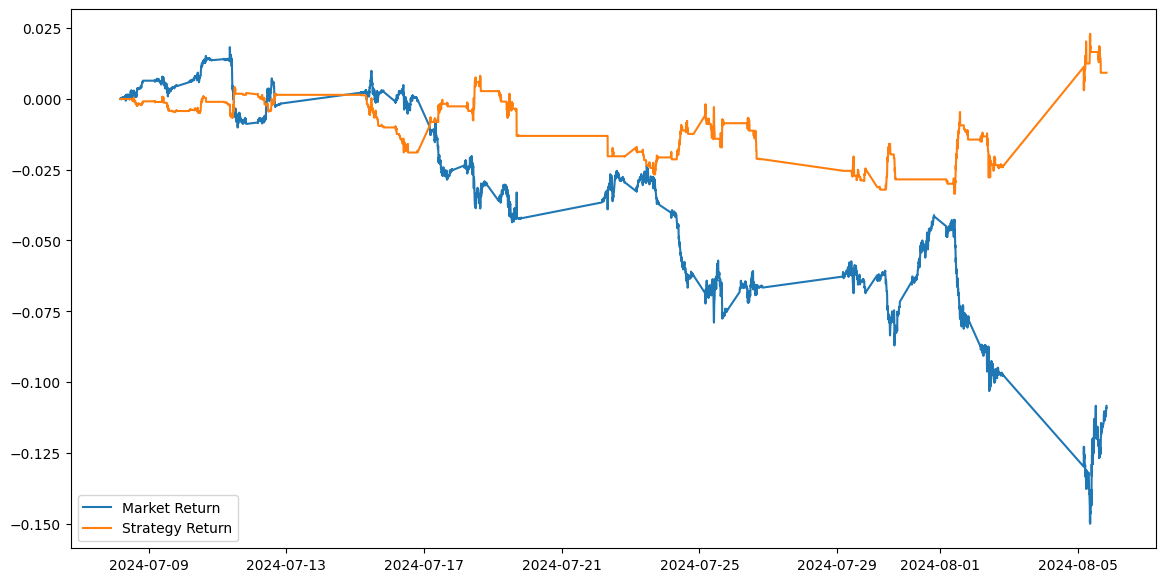

In [195]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(data.index, data['Cumulative_Market_Return'], label='Market Return')
plt.plot(data.index, data['Cumulative_Strategy_Return'], label='Strategy Return')
plt.legend()
plt.show()